<a href="https://colab.research.google.com/github/yijunhou/CS229_Project/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import librosa
import csv
import math
from collections import Counter
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import os
import librosa
import librosa.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import pickle
import joblib
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from IPython.display import Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard

In [ ]:
# test_list = ['2303', '2191', '2382', '2628', '2416', '2556', '2298', '1819', '1759', '2106']
composer_lookup = {"Beethoven":0,"Schubert":1,"Brahms":2,"Mozart":3,"Bach":4,"Dvorak":5,"Cambini":6,"Faure":7,"Ravel":8,"Haydn":9}
# composer_lookup = {"Beethoven":0,"Schubert":1,"Brahms":2,"Mozart":3,"Bach":4}

In [ ]:
#ZD's run
sr = 44100
chunk_seconds = 10
y_train_path = '/content/gdrive/My Drive/CS229/project/Data/ytrnew_' + str(sr) + '_' + str(chunk_seconds) + '.npy'
x_train_path = '/content/gdrive/My Drive/CS229/project/Data/xtrnew_' + str(sr) + '_' + str(chunk_seconds) + '.npy'
y_test_path = '/content/gdrive/My Drive/CS229/project/Data/ytenew_' + str(sr) + '_' + str(chunk_seconds) + '.npy'
x_test_path = '/content/gdrive/My Drive/CS229/project/Data/xtenew_' + str(sr) + '_' + str(chunk_seconds) + '.npy'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def generate_composer_map():
  composer_map = {}
  with open('/content/gdrive/My Drive/CS229/project/Data/musicnet_metadata.csv', 'r' ) as metadata_file:
    reader = csv.DictReader(metadata_file)
    for line in reader:
      composer_map[line['id']] = line['composer']
  return composer_map


In [ ]:
train_data = np.load('/content/gdrive/My Drive/CS229/project/Data/musicnet.npz', encoding='bytes', allow_pickle=True)

In [ ]:
fs = 44100
chunk_size = 10
chunks = int((len(train_data['1789'][0]))/fs/chunk_size)
print("Splitted into "+str(chunks) +" chunks.")

Splitted into 46 chunks.


In [ ]:
composer_map = generate_composer_map()
X, y = [], []
id, composer, key_id, composer_id, piece_id = [], [], [], [],[]
i = 0
for key in list(train_data.keys()):
  chunks = int((len(train_data[key][0]))/fs/chunk_size)
  for piece in range(1, chunks+1):
    key_id.append(key)
    id.append(i)
    piece_id.append(piece)
    com = composer_map[key]
    composer.append(com)
    composer_id.append(composer_lookup[com])
    i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100


In [ ]:
df = pd.DataFrame(list(zip(id, key_id, piece_id, composer, composer_id)), columns = ['ID', 'key_id', 'piece_id', 'composer', 'composer_id'])
df

,ID,key_id,piece_id,composer,composer_id
0,0,1788,1,Mozart,3
1,1,1788,2,Mozart,3
2,2,1788,3,Mozart,3
3,3,1788,4,Mozart,3
4,4,1788,5,Mozart,3
...,...,...,...,...,...
12121,12121,1765,63,Schubert,1
12122,12122,1765,64,Schubert,1
12123,12123,1765,65,Schubert,1
12124,12124,1765,66,Schubert,1


In [ ]:
df.to_csv('/content/gdrive/My Drive/CS229/project/Data/data_file.csv')

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/CS229/project/Data/data_file.csv')

In [ ]:
composers = df["composer"]
print(Counter(composers))

Counter({'Beethoven': 6444, 'Schubert': 1504, 'Brahms': 1143, 'Bach': 1076, 'Mozart': 929, 'Dvorak': 332, 'Cambini': 253, 'Faure': 194, 'Ravel': 163, 'Haydn': 88})


In [ ]:
i= 0
X, y = [], []
for data in tqdm(df.iterrows(),  desc='Progress'):
    key = str(data[1]['key_id'])
    piece = data[1]['piece_id'] -1
    chunks = int((len(train_data[key][0]))/fs/chunk_size)
    a = np.array_split(train_data[key][0], chunks)[piece]
    mfcc_ = librosa.feature.mfcc(a, sr=fs, n_mfcc=40)
    X.append(mfcc_)
    y.append(data[1]['composer_id'])
    if i == 5000:
      break
    else:
      i += 1

Progress: 5000it [00:00, 8245.42it/s]


In [ ]:
X_ = []
for piece in range(len(X)):
  k = X[piece]
  for i in range(len(k)):
    if len(X[piece][i])< 1000:
      pad = 1000 - len(X[piece][i])
      X_.extend([np.hstack([X[piece][i],([0]*pad)])])
      

Text(0.5, 1.0, 'Harmonic Mel Spectogram')

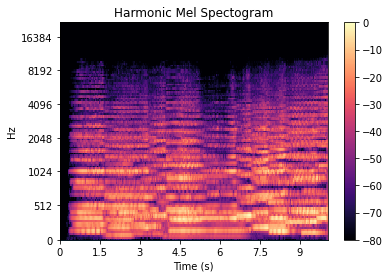

In [ ]:
sr = 44100
a = np.array_split(train_data['1789'][0], chunks)[0]
librosa.display.waveplot(a,sr=fs)
data_h, data_p = librosa.effects.hpss(a)
spec_h = librosa.feature.melspectrogram(data_h, sr=sr)
spec_p = librosa.feature.melspectrogram(data_p, sr=sr)
db_spec_h = librosa.power_to_db(spec_h,ref=np.max)
db_spec_p = librosa.power_to_db(spec_p,ref=np.max)
librosa.display.specshow(db_spec_h,y_axis='mel', x_axis='s', sr=sr)
plt.title("Harmonic Mel Spectogram")
plt.colorbar()

In [ ]:
X_ = np.dstack(X_)

In [ ]:
np.save(x_train_path, x_train)
np.save(y_train_path, y_train)
np.save(x_test_path, x_test)
np.save(y_test_path, y_test)

## **CNN**

In [ ]:
x_train = np.load(x_train_path)
y_train = np.load(y_train_path)
x_rest = np.load(x_test_path)
y_rest = np.load(y_test_path)

x_validation, x_test, y_validation, y_test = train_test_split(x_rest, y_rest, test_size = 0.5, 
                                                   random_state = 42, stratify = y_rest)

print(x_train.shape, x_validation.shape, x_test.shape)

(4000, 40, 1000, 1) (500, 40, 1000, 1) (501, 40, 1000, 1)


In [ ]:
print(Counter([np.where(r==1)[0][0] for r in y_train]),
      Counter([np.where(r==1)[0][0] for r in y_validation]),
      Counter([np.where(r==1)[0][0] for r in y_test]))

Counter({0: 1876, 2: 621, 1: 491, 3: 433, 4: 326, 8: 107, 6: 65, 5: 63, 9: 18}) Counter({0: 234, 2: 78, 1: 61, 3: 54, 4: 41, 8: 14, 5: 8, 6: 8, 9: 2}) Counter({0: 235, 2: 78, 1: 62, 3: 55, 4: 40, 8: 13, 6: 8, 5: 8, 9: 2})


In [ ]:
INPUTSHAPE = (40,1000,1)
model =  models.Sequential([
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 998, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 499, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 497, 128)      36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 249, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 249, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 247, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 124, 128)       0

In [ ]:
batch_size = 8
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(x_train,y_train, validation_data=(x_validation,y_validation), epochs=40, callbacks = [callback],batch_size=batch_size)

Epoch 1/40
500/500 [==============================] - 159s 318ms/step - loss: 1.5705 - acc: 0.4762 - val_loss: 1.5567 - val_acc: 0.4840
Epoch 2/40
500/500 [==============================] - 164s 327ms/step - loss: 1.4821 - acc: 0.4848 - val_loss: 1.4878 - val_acc: 0.4800
Epoch 3/40
500/500 [==============================] - 160s 320ms/step - loss: 1.4673 - acc: 0.4880 - val_loss: 1.4766 - val_acc: 0.4920
Epoch 4/40
500/500 [==============================] - 160s 320ms/step - loss: 1.4588 - acc: 0.4922 - val_loss: 1.4630 - val_acc: 0.4860
Epoch 5/40
500/500 [==============================] - 160s 319ms/step - loss: 1.4500 - acc: 0.4910 - val_loss: 1.4502 - val_acc: 0.4940
Epoch 6/40
500/500 [==============================] - 159s 319ms/step - loss: 1.4376 - acc: 0.4927 - val_loss: 1.4318 - val_acc: 0.4880
Epoch 7/40
500/500 [==============================] - 159s 319ms/step - loss: 1.4126 - acc: 0.4947 - val_loss: 1.3954 - val_acc: 0.4960
Epoch 8/40
500/500 [============================

In [ ]:
model.save('/content/gdrive/My Drive/CS229/project/Model/CNN_1')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/CS229/project/Model/CNN_1/assets


In [ ]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 5s 283ms/step - loss: 0.4772 - acc: 0.8423


[0.4771696925163269, 0.8423153758049011]

In [ ]:
model = models.load_model('/content/gdrive/My Drive/CS229/project/Model/CNN_1')

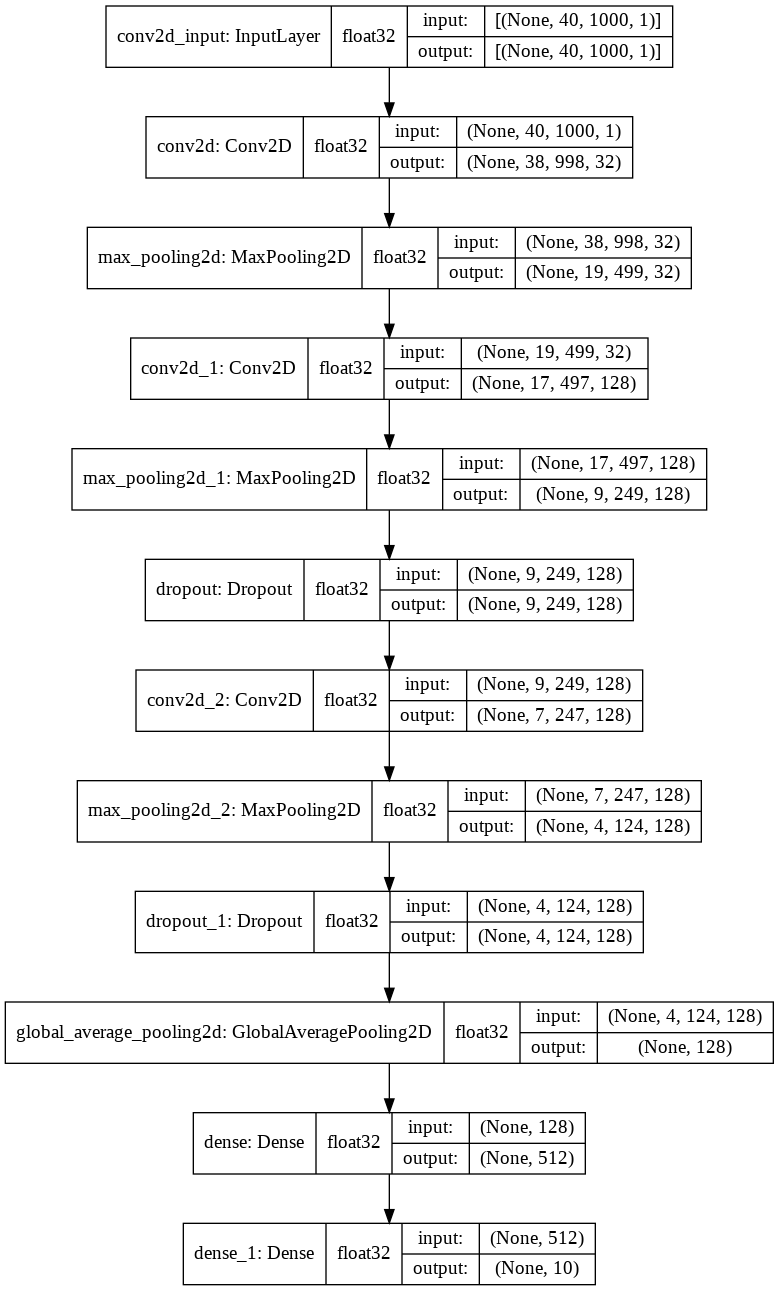

In [ ]:
plot_model(model, to_file='/content/gdrive/My Drive/CS229/project/Model/CNN_1.png', show_shapes=True, show_dtype=True)

## Appendix

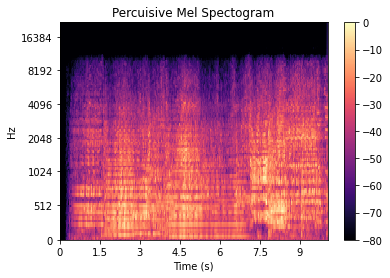

In [ ]:
librosa.display.specshow(db_spec_p,y_axis='mel', x_axis='s', sr=sr)
plt.title("Percuisive Mel Spectogram")
plt.colorbar();

In [ ]:
X_ = X_.reshape(5001, 40, 1000, 1)
y_ = tf.keras.utils.to_categorical(y , num_classes= 10)

x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, 
                                                   random_state = 42, stratify = y_)

shape of mfcc: (40, 864)


<Figure size 1080x432 with 0 Axes>

Text(0.5, 1.0, 'Mel-Frequency Cepstral Coefficients')

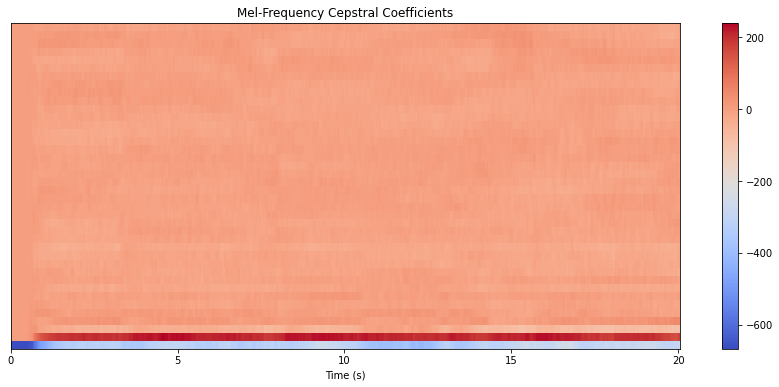

In [ ]:
mfcc=librosa.feature.mfcc(a,sr=sr,n_mfcc=40)
print("shape of mfcc:" ,mfcc.shape)
plt.figure(figsize=(15,6))
librosa.display.specshow(mfcc,x_axis="s")
plt.title("Mel-Frequency Cepstral Coefficients")
plt.colorbar()